In [3]:
%matplotlib inline
import sys, os
sys.path.append("../")
import numpy as np
import scipy as sp
import numpy.linalg as nla
import matplotlib as mpl
import matplotlib.pyplot as plt
from timeit import timeit
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from drot.solver import drot, PDHG
from drot.proximal import *
%load_ext autoreload
%autoreload 2

# Optimal transport

In [5]:
def one_dimensional_gaussian_ot(n):
    t = np.arange(0, n)/n
    Gaussian = lambda t0, sigma: np.exp(-(t-t0)**2 / (2*sigma**2))
    normalize = lambda p: p / np.sum(p)
    sigma = 0.1;
    p = Gaussian(.75, sigma)
    q = Gaussian(.15, sigma)
    vmin = .02;
    p = normalize(p + np.max(p) * vmin)
    q = normalize(q + np.max(q) * vmin)
    [Y,X] = np.meshgrid(t,t)
    C = np.array((X-Y)**2, order='F')
    return n, C, p, q

def two_dimensional_gaussian_ot(n):
    mu_s = np.array([0, 0])
    cov_s = np.array([[1, 0], [0, 1]])
    mu_t = np.array([4, 4])
    cov_t = np.array([[1, -.8], [-.8, 1]])
    xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((n,)) / n, np.ones((n,)) / n  
    C = np.array(ot.dist(xs, xt), order='F')
    C /= C.max()

    return n, C, p, q

Solve time:  0.28284597396850586
Solve time:  0.23169922828674316


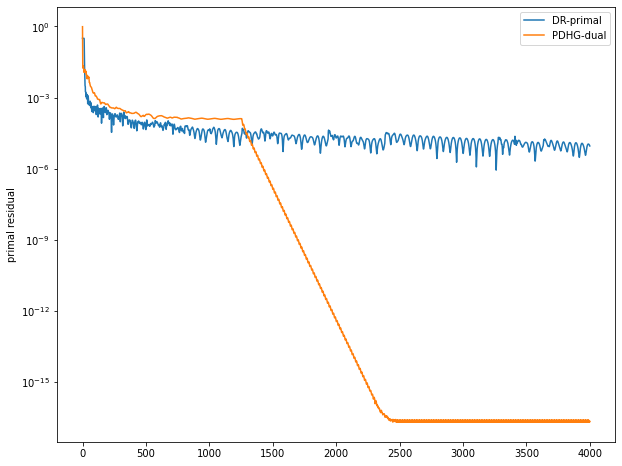

In [77]:
max_iters = 4000
step = 0.01

n, C, p, q = two_dimensional_gaussian_ot(20)
x0 = np.ones((n,n), order='F')/n
eta, tau = (1/(2*n))**0.5, (1/(2*n))**0.5

assert C.flags['F_CONTIGUOUS']   
assert x0.flags['F_CONTIGUOUS']   

proxf = lambda x, stz: trace_nonnegative_prox(x, C, stz)
proxg = lambda x: generalized_doubly_stochastic_matrices_projection(x, p, q)
proxg_ = lambda x, y, stz: primal_dual_trace_nonnegative_prox(x, C, y, stz)
proxh = lambda x, xnew, y, stz: primal_dual_linear_prox(x, xnew, y, p, q, stz)

drout  = drot(x0, proxf, proxg, np.vstack((p,q)), max_iters, step=step, relaxation=1.5, compute_r_primal=True, compute_r_dual=True, adapt_stepsize=False)
cpout  = PDHG(x0, proxg_, proxh, max_iters, eta=eta, tau=tau, relaxation=1.0)

xopt = drout["sol"]
xopt_cp = cpout["sol"]

plt.figure(1, figsize=(10,8))
plt.plot(range(drout["num_iters"]), [r for r in drout['primal']], label='DR-primal')
# plt.plot(range(drout["num_iters"]), [r for r in drout['dual']], label='DR-dual')
plt.ylabel("primal residual") 
plt.yscale('log')
plt.legend()

# plt.figure(2, figsize=(10,8))
plt.plot(range(cpout["num_iters"]), [r for r in cpout['dual']], label='PDHG-dual')
# plt.ylabel("primal residual") 
plt.yscale('log')
plt.legend()

In [19]:
%reload_ext memory_profiler
# from performance_memory_profiler import test_caching_function, simple_function
def run():
    drot(x0, proxf, proxg, np.vstack((p,q)), max_iters, step=step, relaxation=1.5, compute_r_primal=True, compute_r_dual=True, adapt_stepsize=False)

In [21]:
%mprun -T test_mprun.txt -f run()

Solve time:  1.8721437454223633


*** Profile printout saved to text file test_mprun.txt. 


In [30]:
a= np.zeros(5)
b = np.ones(5)
c = np.vstack((a,b))
d= np.hstack((a,b))

In [36]:
c.size

10

In [22]:
%cat test_mprun.txt

In [2]:
C_ = C.copy()
G0 = ot.emd(p, q, C_)
Gs = ot.sinkhorn(p, q, C_, 1e-3, verbose=False)
nla.norm(xopt.T - G0, ord='fro'),\
nla.norm(Gs - G0, ord='fro')

KeyboardInterrupt: 

In [87]:
np.trace(xopt.T.dot(C)), np.trace(G0.T.dot(C_)), np.trace(Gs.T.dot(C_))

(0.3681665253320586, 0.36810719274509734, 0.3684367081458483)

Text(0.5, 1.0, 'OT matrix Sinkhorn')

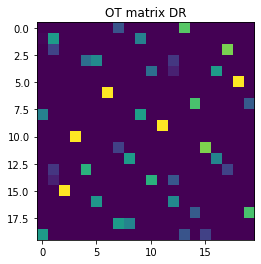

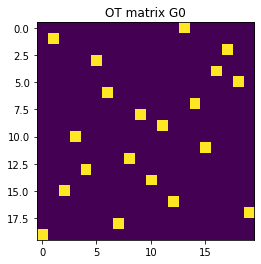

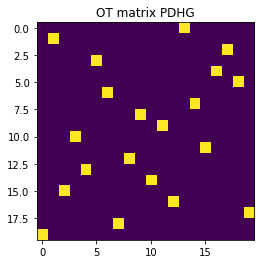

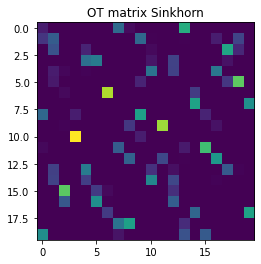

In [88]:
pl.figure(1)
pl.imshow(xopt, interpolation='nearest')
pl.title('OT matrix DR')

pl.figure(2)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
pl.imshow(xopt_cp, interpolation='nearest')
pl.title('OT matrix PDHG')

pl.figure(3)
pl.imshow(Gs, interpolation='nearest')
pl.title('OT matrix Sinkhorn')

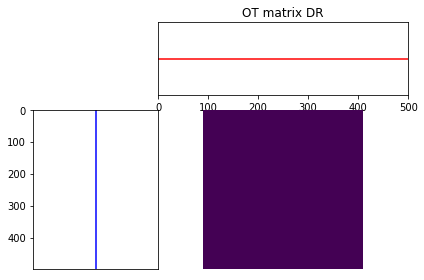

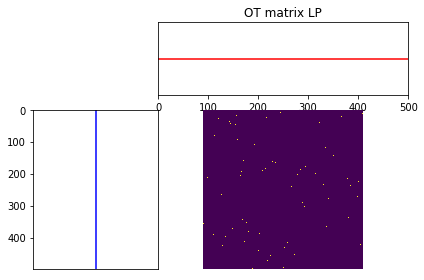

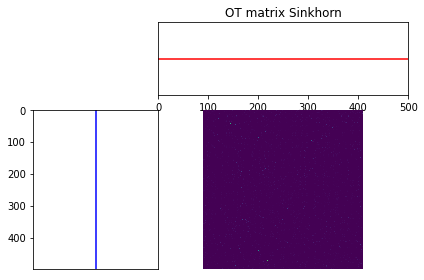

In [39]:
pl.figure(3, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, xopt.T, 'OT matrix DR')
# pl.title("---")

pl.figure(6, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, G0, 'OT matrix LP')

pl.figure(9, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, Gs, 'OT matrix Sinkhorn')
pl.show()

In [47]:
import scipy
m, n = 10000, 5000
A = np.random.randn(m, n)
x = np.random.randn(m)
y = np.random.randn(n)
r = np.random.rand(n)
s = np.random.rand(m)
r, s = r / np.sum(r), s / np.sum(s)

B = np.array(A, order='F')
assert np.allclose(A, B)

# def numpy_run1(A):
#     A_ = A.copy()
#     A_ += np.outer(x, y)

# def scipy_run(A):
#     B = np.array(A, order='F')
#     assert B.flags['F_CONTIGUOUS']
#     scipy.linalg.blas.dger(1, x, y, a=B, overwrite_a=1)

# f1 = lambda: numpy_run1(A)
# ts_md = timeit(f1, number=1)
# print(ts_md)

# f2 = lambda: scipy_run(B)
# ts_md = timeit(f2, number=1)
# print(ts_md)

# assert np.allclose(A, A_)

In [49]:
%timeit A.dot(y)

19.9 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
m, n = 5000, 5000
A = np.random.randn(m, n)
x = np.random.randn(m)
y = np.random.randn(n)
r = np.random.rand(n)
s = np.random.rand(m)
r, s = r / np.sum(r), s / np.sum(s)
e = np.ones(n)
f = np.ones(m)

B = np.array(A, order='F')
C = np.zeros((m,n))

In [407]:
f1 = lambda: projection_1(A, s, r)
ts_md = timeit(f1, number=1)
print(ts_md)

f2 = lambda: projection_2(B, s, r)
ts_md = timeit(f2, number=1)
print(ts_md)


0.40367177900043316
0.10778809300245484


In [33]:
def Sinkhorn(C, reg, a, b, delta=1e-9, lam=1e-6):

    K = np.exp(-C / reg)
    u = np.ones(np.shape(a)[0])
    v = np.ones(np.shape(b)[0])

    u_trans = np.dot(K, v) + lam  # add regularization to avoid divide 0
    v_trans = np.dot(K.T, u) + lam  # add regularization to avoid divide 0

    err_1 = np.sum(np.abs(u * u_trans - a))
    err_2 = np.sum(np.abs(v * v_trans - b))

    while True:
        if err_1 + err_2 > delta:
            u = a / u_trans
            v_trans = np.dot(K.T, u) + lam

            v = b / v_trans
            u_trans = np.dot(K, v) + lam

            err_1 = np.sum(np.abs(u * u_trans - a))
            err_2 = np.sum(np.abs(v * v_trans - b))
        else:
            return u, v



In [ ]:
# proxf_ = lambda x: nonneg_projection(x -  step * C_)
# proxg_ = lambda x: generalized_doubly_stochastic_matrices_projection_(x, p, q)